## 本課程由成大與台南二中共同開發的人工智慧高中教材改編

# 實作範例 5 - 增強式學習 Reinforcement Learning

歡迎大家來到增強式學習（又稱強化學習）的世界！增強式學習不同於前面章節介紹過的，利用已知資料來訓練機器；而是**透過「環境」對於機器的「行動」所給予的「獎勵或懲罰」來影響及訓練機器的決策**，讓機器表現愈來愈好的一種學習方式。就像我們在成長的過程中，做錯事了會被懲罰；而做得很棒會被獎勵一樣，增強式學習正是利用這樣的概念來訓練機器的。

本章實作範例將藉由 [**OpenAI Gym**](https://gym.openai.com) 套件，來模擬增強式學習中的**環境**，讓我們在其上實作及驗證我們的演算法。OpenAI Gym 是一套提供許多「環境」供增強式學習演算法實作與驗證的平台。如果不依靠 OpenAI Gym，我們除了實作演算法 (如課堂介紹的 [Q-Learning](https://zh.wikipedia.org/zh-tw/Q學習)) 之外，我們也必須要自行設計一套「環境」給演算法跑，包括：根據演算法的行動給予獎勵或懲罰、判斷某個特定目標是不是已經完成或失敗了、提供演算法目前的狀態﹍等。由於自行設計與開發環境包含了上面許多與演算法本身無關的雜事，為了讓使用者**有一個共同的測試環境與專注於開發與驗證增強式學習的演算法**，OpenAI Gym 出現了，它幫你把一系列的雜事都包了！讓你能專心搞定演算法，而不用為了環境的事煩心。

那什麼是「環境」呢？聽請來很抽象，但概念其實很簡單。假設我們今天要讓機器學習玩[打磚塊](https://www.google.com.tw/search?q=打磚塊&tbm=isch)，這個遊戲本身就是一個「環境」。而此時機器能做的「行動」，也就是玩家能做的事情，就是將遊戲畫面下方的板子左右移動。而根據這些行動，環境需要判斷：球是不是掉下去了、球是不是有彈起來、球有沒有打到磚塊、打到多少磚塊、玩家是不是將所有的磚塊都消去了 (成功！)、是不是所有的生命都用完了 (失敗！)﹍等等。而根據這些機器行動後的結果，環境需要給機器回饋，例如碰到磚塊的話就給正向回饋、球掉下去就給負面回饋等。這些就是一個「環境」需要做的事，也就是 OpenAI Gym 幫我們做的事。

## OpenAI Gym 環境設定

### 安裝 OpenAI Gym

OpenAI Gym 與之前介紹的其他 Python 套件相同，使用 `pip` 安裝即可（或是在 Anaconda 上使用 `conda` 命令）：

```
pip install gym
```

### &star; 使用遠端伺服器或 Google Colab 上之 Jupyter Notebook 需進行的額外設定 &star;

我們利用 OpenAI Gym 時會將環境的狀態顯示在螢幕上，但在如 [Google Colab](https://medium.com/@ericsk/9f92c7bb1f50) 等*遠端*環境中，由於我們的螢幕並沒有真的連接到遠端伺服器，所以無法直接看到 OpenAI Gym 所秀出來的環境狀態。因此需要額外安裝一些套件與執行額外設定，讓我們能看到遠端執行的 OpenAI Gym 的結果。

若同學是在**遠端伺服器或 Google Colab 上之 Jupyter Notebook** 執行本範例，請執行底下的指令與程式碼安裝必要套件與進行設定：

In [0]:
## 若使用遠端伺服器或 Google Colab 上之 Jupyter Notebook 者，請執行本區塊指令 ##
!apt-get install -y xvfb x11-utils > /dev/null
!pip install gym pyvirtualdisplay PyOpenGL > /dev/null

如果以上的執行結果沒有任何輸出，就表示成功了。接著請執行以下 Python 程式碼：

In [0]:
## 若使用遠端伺服器或 Google Colab 上之 Jupyter Notebook 者，請執行本區塊程式 ##
import gym # 載入 OpenAI Gym
import matplotlib.pyplot as plt # 載入 matplotlib，幫我們顯示遠端 OpenAI Gym 執行的結果
from IPython import display as ipythondisplay # 控制 IPython 環境中的顯示
from pyvirtualdisplay import Display # 虛擬顯示裝置

# 產生一個 Display 物件，並且設定在 Google Colab 上的顯示參數
display = Display(visible=0, size=(1024, 768))
display.start()

# Making a monkey patch to maintain the consistency of APIs in both settings
gym.Wrapper.orig_render = gym.Wrapper.render
gym.Wrapper.orig_close  = gym.Wrapper.close

def new_render(self):
    self.vscreen = self.orig_render(mode='rgb_array')
    plt.imshow(self.vscreen)
    ipythondisplay.clear_output(wait=True) 
    ipythondisplay.display(plt.gcf())

def new_close(self):
    ipythondisplay.clear_output(wait=True)
    self.orig_close()

gym.Wrapper.render = new_render
gym.Wrapper.close  = new_close

### 載入套件

接著載入需要的 Python 套件：

In [0]:
import gym # 載入 OpenAI Gym
import math # 載入數學運算模組
import numpy as np # 載入 NumPy

設定完了之後，我們就可以準備進入 OepnAI Gym 的世界了！

## 初探 OepnAI Gym

我們從一個最簡單的環境：「**CartPole-v0** ([官網介紹](https://gym.openai.com/envs/CartPole-v0/), [詳細資訊](https://github.com/openai/gym/wiki/CartPole-v0))」開始，這是在增強式學習中其中一個最知名的問題。在這個環境中，有一根棒子垂直放在一個會移動的平台上，而我們必須要左右移動這個平台，維持棒子的平衡。同學們可以自行想像一下*將一根掃把棍頂在頭上，然後想辦法左右移動讓這個掃把棍不要掉下來*﹍﹍這個環境差不多就是在做這件事。

OpenAI Gym 的[官方網站](https://gym.openai.com/envs)上有列出它所提供的所有環境 (在 GitHub 的 wiki 上也有一張[列表](https://github.com/openai/gym/wiki/Table-of-environments)，詳細比較了各個不同環境的參數)。

我們先看一下以下的程式碼：

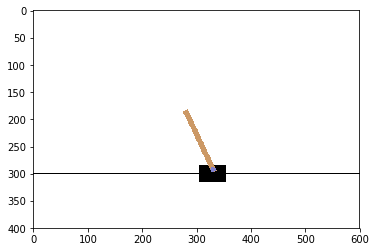

In [5]:
env = gym.make('CartPole-v0') # 創造一個 CartPole-v0 環境
env.reset() # 初始化/重設環境狀態
for t in range(20): # 讓它跑 20 個間點 (行動 20 次)
    env.step(env.action_space.sample()) # 隨機做一個行動
    print("現在是第 {} 個時間點".format(t+1))
    env.render() # 顯示目前的環境狀態
env.close()

執行後，同學們應該可以看見一根棒子與平台在移動，這就是最簡單的 OpenAI Gym 程式：

1. 程式一開始，我們先使用 `gym.make()` 來創造一個**環境**，程式碼中我們填上 `'CartPole-v0'` 代表使用「CartPole-v0」這個環境。如果填上不同的值，代表創造其他的環境 (例如 `'MountainCar-v0'`, `'Acrobot-v1'`, `'Pendulum-v0'` 等，同學們可以自行嘗試。*但 OpenAI Gym 網站上的部份環境可能需要額外安裝其他套件*)。
2. 接著呼叫 `reset()` 來初始化環境的**狀態**。
3. 然後設定一個跑 20 次的迴圈，裡面我們呼叫了 `render()`，代表把目前的狀態顯示在畫面上；`step()` 則代表**做出行動**，我們這邊先讓電腦在每一個時間點都隨機選一個行動（細節稍後講解）。
4. 最後等迴圈跑完之後，我們呼叫 `close()` 將這個環境給結束。

### 與環境互動

增強式學習中強調**「機器 (agent)」與「環境 (environment)」的互動**，以上的步驟簡單地呈現了機器與環境的互動過程。但我們知道，當機器在環境中做出「行動 (action)」後，環境會給予對於該行動之「獎勵 (reward)」與行動完後環境的「狀態 (observation/state)」：

`[機器 (agent)]` &rarr;&rarr;&rarr; `做出行動 (action)` &rarr;&rarr;&rarr; `[環境 (environment)]`

`[機器 (agent)]` &larr;&larr;&larr; `獲得獎勵 (reward) & 行動後狀態 (observation/state)` &larr;&larr;&larr; `[環境 (environment)]`

有了以上概念後，我們稍微擴充一下之前的程式碼：

環境已達終止條件，總共獲得獎勵： 29.0


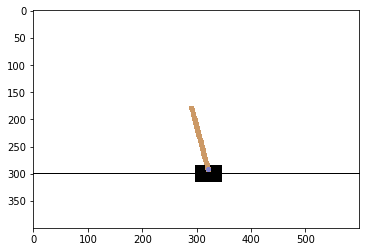

In [0]:
env = gym.make('CartPole-v0') # 創造一個 CartPole-v0 環境
observation = env.reset() # 初始化/重設環境狀態，該函式會回傳環境的初始狀態

total_rewards = 0.0
for t in range(50): # 至多行動 50 次
    action = env.action_space.sample() # 隨機選一個行動
    observation, reward, done, info = env.step(action) # 執行行動，並接收行動後的獎勵與環境狀態
    total_rewards += reward
    
    print("現在是第 {} 個時間點，獲得獎勵 {}，累計獎勵 {}，是否達終止條件？ {}".format(t+1, reward, total_rewards, done))
    env.render() # 顯示目前的環境狀態
    
    if done: # 若達終止條件，則結束執行
        break

env.close()

print("環境已達終止條件，總共獲得獎勵：", total_rewards)

首先注意到，在 `observation, reward, done, info = env.step(action)` 這行程式中，`env.step()` 函數前多了四個變數，這些變數正是我們在行動後，環境回傳給我們的**行動獎勵**與**行動後狀態**，這四個變數依照順序分別為：
 * `observation`: (執行該行動後) 環境的狀態
 * `reward`: (執行該行動後) 所獲得的獎勵
 * `done`: (執行該行動後) 是否已達終止條件
 * `info`: Debug (除錯) 用的資訊

`observation` 與 `reward` 會根據各環境不同而有自己的定義，而 `done` 代表的則是該環境是否已達到「**終止條件**」。什麼是終止條件呢？以前面提過的打磚塊遊戲為例，就是*造成遊戲結束的條件*。當遊戲結束時，可能是玩家*成功地消去了所有磚塊（破關）*，或者是*所有的球都掉下去了（game over）*。當回傳的 `done` 被設為 `True` 時，代表這個環境可能已達成 (或已不可能達成) 某種目標，提示機器不需要再進行下去了。

我們所設計的演算法，最終的目標就是要**在達到終止條件前，獲得最多的獎勵**。以範例中的 CartPole-v0 環境為例，只要每多存活一個時間點，就會獲得 1 點獎勵。所以我們的目標就是要控制平台左右移動，讓棒子盡量保持平衡而不掉下來。我們目前在選擇行動的時候是隨便選，這樣得到的分數只有少少的十幾二十幾分，後面我們要以能夠突破這個分數為目標前進！

至於 `info` 是一個 `dict` 物件，裡面有方便程式設計師除錯的資訊，內容也會根據環境的不同而有所改變。（註：[官方的教學](https://gym.openai.com/docs/)上面有特別提到，這個變數中可能會含有一些「不應該」被觀察到的資訊，提供這些資訊僅是方便除錯工作，在正式對演算法做測試與評估時，是嚴格禁止讀取裡面的資訊作為演算法之判斷依據的。）

了解回傳值的內容後可以明白，**在 OpenAI Gym 中，我們就是透過 `step()` 來讓電腦與環境進行互動**的。往後我們的程式邏輯，可以依照底下幾個步驟進行：
 1. 初始化環境 (`reset()`) ，得到環境的**初始狀態** (`observation`)
 2. 根據最初的環境選擇一個**行動** (`step()`)
 3. 從 `step()` 的結果中獲得該行動後的**環境狀態**與**獎勵**
 4. 根據上一次行動後的環境狀態與獲得獎勵，讓機器學習，然後選擇一個**最佳行動** (`step()`)
 5. 回到第 3. 步，直到環境達到**終止條件**



### OpenAI Gym 中的 Space

（註：這一小節中提到的關於 CartPole-v0 環境的細節，在 [OpenAI Gym 的 wiki 上](https://github.com/openai/gym/wiki/CartPole-v0)有更詳細的資料與解說，老師鼓勵同學們可以直接閱讀 wiki 上的資料，會比較有幫助喔！）

#### Observation Space (狀態空間)

了解在 OpenAI Gym 上機器如何與環境互動後，我們接下來看看機器回傳給我們的 observation 裡面有什麼：

In [0]:
env = gym.make('CartPole-v0')
observation = env.reset()
observation

array([ 4.46299119e-02,  1.28613260e-02, -4.83290144e-05, -4.59956610e-02])

可以看到裡面有 4 個值，依照 [wiki 上的說明](https://github.com/openai/gym/wiki/CartPole-v0)，這四個值分別是：
 * 平台的位置 (有效值：-2.4 ~ 2.4)
 * 平台的移動速度 (有效值：-&infin; ~ +&infin;)
 * 棒子的傾斜角度 (有效值：-41.8° ~ 41.8°)
 * 棒子的末端速度 (有效值：-&infin; ~ +&infin;)

我們把這些狀態上的*變數組合*稱為「**observation space**」，用來**描述環境的格式和範圍**。每個環境狀態的格式可以透過 `observation_space` 屬性取得：

In [0]:
env.observation_space

Box(4,)

我們可以看到在 CartPole-v0 中，用來描述環境的格式是 `Box(4,)`，`Box` 類型的物件，用來表示一個 $n$ 維的*盒子*，所以在上面我們會發現 `observation` 是一個長度為 4 的陣列，而陣列中的每個變數都有上下界（可以利用 `observation_space.high` 與 `observation_space.low` 查看），看起來就像一個盒子一般。

#### Action Space (行動空間)

除了 observation space 外，OpenAI Gym 還有另一個空間，稱為「**action space**」，用來描述有效的動作範圍。每個環境中 action space 的格式可以透過 `action_space` 屬性取得：

In [0]:
env.action_space

Discrete(2)

`Discrete(n)` 類別的物件是一個 $\{0, 1, \dots, n-1\}$ 的*非負整數*集合。在 CartPole-v0 例子中，action space 的格式為 `Discrete(2)`，代表該環境中有效的行動為 $\{0, 1\}$，分別代表將平台推往左邊與右邊。

`Discrete` 物件有一個方法叫 `sample()`，其意義是隨機從 action space 中挑選一個動作。我們在前面的程式中，正是透過這個方法來讓電腦幫我們隨機挑選行動的：

In [0]:
env.action_space.sample()

0

同學們可以重複執行上一行程式，看看是不是會隨機出現不同數字呢？

## 改進策略之 1：先來惡搞一下

了解 OpenAI Gym 的基本概念後，我們終於可以來開始改進我們的策略了！

但在那之前，我們先來試試，如果讓車子只往一邊跑會發生什麼事XD：

環境已達終止條件，總共獲得獎勵： 10.0


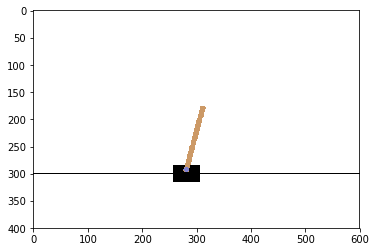

In [6]:
env = gym.make('CartPole-v0')
observation = env.reset()

# 隨機從 action space 中挑一個動作，然後從頭到尾只做它XD
action = env.action_space.sample() 

total_rewards = 0.0
for t in range(50): # 至多行動 50 次
    observation, reward, done, info = env.step(action)
    total_rewards += reward
    
    print("現在是第 {} 個時間點，獲得獎勵 {}，累計獎勵 {}，是否達終止條件？ {}".format(t+1, reward, total_rewards, done))
    env.render() # 顯示目前的環境狀態
    
    if done: # 若達終止條件，則結束執行
        break

env.close()

print("環境已達終止條件，總共獲得獎勵：", total_rewards)

好的，如果一直讓滑車往左或右跑的話，一下子遊戲就停掉了，才獲得 10 分的獎勵而已，甚至比隨機選的結果還差！

## 改進策略之 2：來個工人智慧

很顯然，無腦的走法是沒有用的（廢話），為了讓 agent 不會走得太無腦，我們再來引進一個簡單的策略：如果棒子向左傾（角度 < 0），則平台小車向左移以維持平衡；否則往右移。

我們來將上述策略寫成一個函式：

In [0]:
# 定義策略
def choose_action(observation):
    pos, v, ang, rot = observation # observation space 中的四個值
    return 0 if ang < 0 else 1 # 柱子左傾則小車左移，否則右移 

定義完了策略之後，我們將 `choose_action()` 放入我們的程式中，這次我們一次來跑個 200 輪（跑一次完整的遊戲，英文術語稱為「episode」）試試看：

In [0]:
env = gym.make('CartPole-v0')

# 來一次跑個 200 輪試試看
# 由於跑 200 次有點久，從這開始我們就不顯示環境狀態囉，改為直接印出每一輪的結果
total_rewards = []
for i_episode in range(200): 
    observation = env.reset()
    rewards = 0.0

    for t in range(50): # 至多行動 50 次
        observation, reward, done, info = env.step( choose_action(observation) )
        rewards += reward
        
        if done: # 若達終止條件，則結束執行
            print("本輪 {} 回合，共獲得獎勵：{}".format(t+1, rewards) )
            total_rewards.append(rewards)
            break

total_rewards = np.array(total_rewards)
print("平均獲得獎勵：", total_rewards.mean() )
print("最多的一次：", total_rewards.max() )
print("最少的一次：", total_rewards.min() )

本輪 45 回合，共獲得獎勵：45.0
本輪 25 回合，共獲得獎勵：25.0
本輪 46 回合，共獲得獎勵：46.0
本輪 31 回合，共獲得獎勵：31.0
本輪 38 回合，共獲得獎勵：38.0
本輪 45 回合，共獲得獎勵：45.0
本輪 42 回合，共獲得獎勵：42.0
本輪 49 回合，共獲得獎勵：49.0
本輪 39 回合，共獲得獎勵：39.0
本輪 38 回合，共獲得獎勵：38.0
本輪 31 回合，共獲得獎勵：31.0
本輪 37 回合，共獲得獎勵：37.0
本輪 40 回合，共獲得獎勵：40.0
本輪 39 回合，共獲得獎勵：39.0
本輪 41 回合，共獲得獎勵：41.0
本輪 35 回合，共獲得獎勵：35.0
本輪 31 回合，共獲得獎勵：31.0
本輪 44 回合，共獲得獎勵：44.0
本輪 45 回合，共獲得獎勵：45.0
本輪 47 回合，共獲得獎勵：47.0
本輪 48 回合，共獲得獎勵：48.0
本輪 49 回合，共獲得獎勵：49.0
本輪 38 回合，共獲得獎勵：38.0
本輪 49 回合，共獲得獎勵：49.0
本輪 36 回合，共獲得獎勵：36.0
本輪 35 回合，共獲得獎勵：35.0
本輪 44 回合，共獲得獎勵：44.0
本輪 45 回合，共獲得獎勵：45.0
本輪 35 回合，共獲得獎勵：35.0
本輪 34 回合，共獲得獎勵：34.0
本輪 25 回合，共獲得獎勵：25.0
本輪 35 回合，共獲得獎勵：35.0
本輪 45 回合，共獲得獎勵：45.0
本輪 42 回合，共獲得獎勵：42.0
本輪 36 回合，共獲得獎勵：36.0
本輪 34 回合，共獲得獎勵：34.0
本輪 34 回合，共獲得獎勵：34.0
本輪 38 回合，共獲得獎勵：38.0
本輪 50 回合，共獲得獎勵：50.0
本輪 45 回合，共獲得獎勵：45.0
本輪 41 回合，共獲得獎勵：41.0
本輪 25 回合，共獲得獎勵：25.0
本輪 35 回合，共獲得獎勵：35.0
本輪 25 回合，共獲得獎勵：25.0
本輪 39 回合，共獲得獎勵：39.0
本輪 47 回合，共獲得獎勵：47.0
本輪 39 回合，共獲得獎勵：39.0
本輪 26 回合，共獲得獎勵：26.0
本輪 45 回合，共獲得獎勵：45.0
本輪 39 回合，共獲得獎勵：39.0


可以看到這樣簡單的策略，也比起之前略有改進囉！但好，還能更好！

## 改進策略之 3：利用 Q-Learning

接著我們就來利用課堂上學習過的 Q-Learning 來改進策略吧！

### 回顧 Q-Learning 基本概念

我們說增強式學習是基於「環境對於機器做出的動作所給予的回饋」學習的。在經過學習之後，機器會在不同的環境狀態中選擇最佳（能獲得最多獎勵）的行動，在 Q-Learning 中，我們把機器在某**狀態**下執行某**行動**的「*價值*」量化為 **Q (Quality) 值**，這個值是*愈高愈好*。而我們會把一個環境下的所有 Q 值存在一個 **Q-Table (Q 表)** 中。舉個例子，若今天某環境下有 3 種狀態，每個狀態下皆可執行 2 種行動，那麼 Q-Table 就會長得像這樣：

|    Q-Table    | ( Action 1 ) | ( Action 2 ) |
|---------------|--------------|--------------|
| **(State 1)** | $Q(s_1,a_1)$ | $Q(s_1,a_2)$ |
| **(State 2)** | $Q(s_2,a_1)$ | $Q(s_2,a_2)$ |
| **(State 3)** | $Q(s_3,a_1)$ | $Q(s_3,a_2)$ |

若假設機器位於 State 2 ($s_2$)，那麼機器就會選擇 State 2 那一列中 ($Q(s_2,a_1)$, $Q(s_2,a_2)$) Q 值最高的那個行動作為最佳行動。Q-Learning 演算法的核心就在於機器經過一次又一次的嘗試，Q-Table 中的 Q 值會不斷地被更新。我們在課堂中提過，Q 值會被兩種因素所影響（基於[貝爾曼方程](https://en.wikipedia.org/wiki/Bellman_equation)所設計）：
 * 選了這個行動後可以立即獲得的獎勵 ($R(s,a)$)
 * 移動到下一個狀態後可以獲得的最大 Q 值（下一個狀態中所有可能行動的 Q 值最大者）($\max_{a}Q(s_{next},a)$)

換句話說，Q 值能夠估計在某狀態下選擇某行動所產生的獎勵（故 Q 亦稱「價值函數 (Value function)」），可以寫成如下的公式：

$$Q'(s,a) = R(s,a) + \gamma \max_{a}Q(s_{next},a)$$

而 Q 值的更新方式有很多種，課堂上我們介紹了「**Temporal Difference, TD** (時值差異，又稱時間差分)」法，藉由定義一個 TD 值來代表**新舊 Q 值的差異**：

\begin{align}
TD(s,a) & = Q'(s,a) - Q(s,a) \\
        & = R(s,a) + \gamma \max_{a}Q(s_{next},a) - Q(s,a)
\end{align}

然後將舊的 Q 值加上*加權過*的 TD 值就是更新後的 Q 值：

\begin{align}
Q^{new}(s,a) & = Q(s,a) + \alpha TD(s,a) \\
             & = Q(s,a) + \alpha [R(s,a) + \gamma \max_{a}Q(s_{next},a) - Q(s,a)] 
\end{align}

以上就是更新 Q 值的完整公式，其中：
 * $\gamma$ (gamma) 稱為「**衰減係數 (Discount factor)**」(範圍：$0 \le \gamma \le 1$)：用來控制*下個狀態的 Q 值對當前 Q 值的影響力*。這個值愈大，代表「未來決策的影響力愈大」，也就是將眼光放遠，注重長期利益；相反地，若這個值愈小，能馬上獲得的獎勵愈重要，某種程度上可視為「注重短期利益」。衰減係數並沒有公認要使用多少比較好，而是依照環境的性質做調整。
 * $\alpha$ (alpha) 稱為「**學習速率 (Learning rate)**」(範圍：$0 \lt \alpha \le 1$)：用來控制 *TD 值影響原 Q 值的程度*。這個值愈大代表傾向採用新的 Q 值來取代舊 Q 值，也就是變動幅度較大；愈小代表傾向保留舊 Q 值，也就是變動幅度較小。而這個值的大小也是依據使用的場景而有所不同，甚至有時候也要依據跑的輪數而有所變動。

回顧完 Q-Learning 後，我們就開始著手設計程式吧！

### 建立 Q-Table

首先我們先著手建立 Q-Table，要建立 Q-Table 時，需要知道**狀態與行動的數量**，我們可以使用前面提過的 `observation_space` 與 `action_space` 得知。

另外還有一個問題，Q-Table 中的狀態數量是「有限」的，但是依照 wiki 上關於 CartPole-v0 的定義，其四個觀察值都是連續的，也就是會有「無限」個狀態。為了克服這個問題，我們需要將狀態有限化，方法是將依照觀察值的特性，分成數個*區段*作為狀態。假設我們定義某觀察值的上下界是 10 ~ 20，分成 4 個狀態，我們可以這樣分配：

| 觀察值 | 狀態 |
|-------|---------|
| ~ 12.5 | 狀態 1 |
| 12.5 ~ 15.0 | 狀態 2 |
| 15.0 ~ 17.5 | 狀態 3 |
| 17.5 ~ | 狀態 4 |

狀態的數量與值的上下界可以根據*這個狀態是否重要*及*觀察值的分佈程度*而定。若觀察值在某個區間分佈非常密集，而在這個區間中微小的數值差異可能導致結果很不同，就可以考慮對這個區間細分多一點狀態。

最後，我們要初始化 Q-Table，Q-Table 中一開始每個值都會是一個固定數字，通常及本範例中會定為 0.0；不過[也有學者指出](http://incompleteideas.net/book/first/ebook/node21.html)給定一個較大的值會有助於學習。

以下是這一段的範例程式碼：

In [0]:
## 建立 Q-Table ##

env = gym.make('CartPole-v0') # 新創造一個 CartPole-v0' 環境

# 環境中各個觀察值的狀態分配數量
# 1 代表任何值皆表示同一 state，也就是這個觀察值其實不重要
n_buckets = (1, 1, 6, 3) # CartPole-v0 中四個觀察值分別給予的狀態數量
                         # **這些值同學們可以自由進行替換，這邊先代入編者們調校過的數值**

# CartPole-v0 的 Action 數量 
n_actions = env.action_space.n # 可以用 Discrete 的 n 這個屬性來取得 action 的數量

# 取得各觀察值的上下界
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
# 由於平台的移動速度及棒子末端速度原來的上下界是：負無限大～無限大，範圍過廣，故我們需手動設定合理的範圍取代之
# **這些值同學們也可以自由進行替換，這邊先代入編者們調校過的數值**
state_bounds[1] = [-0.5, 0.5] 
state_bounds[3] = [-math.radians(50), math.radians(50)]

# 建立 Q-Table
# 這裡我們用 np.zeros() 將內部的值都初始化為 0.0
# 若要用其他值初始化，可以使用 np.full()，它比 np.zeros() 多加一個參數來指定初始值
q_table = np.zeros(n_buckets + (n_actions,)) # 每個 state-action pair 存一個 Q 值
                                             # 以我們的預設值來說這裡會產生一個形狀為 (1,1,6,3,2) 的五維陣列
                                             # 也就是共 1*1*6*3 種「狀態組合」，每種狀態組合會有代表兩種行動的 2 個 Q 值
                                             # 合計共 1*1*6*3*2 個 Q 值

# 寫一個函數將觀察值轉為狀態組合
# 我們會用這個狀態組合作為 Q-Table 的索引來找到正確的 Q 值
def get_state(observation, n_buckets, state_bounds):
    state = [0] * len(observation) 
    for i, s in enumerate(observation): # 每個觀察值有不同的分配
        l, u = state_bounds[i][0], state_bounds[i][1] # 每個觀察值值的範圍上下限
        if s <= l: # 低於下限，分配為值最低的那個狀態
            state[i] = 0
        elif s >= u: # 高於上限，分配為值最高的那個狀態
            state[i] = n_buckets[i] - 1
        else: # 範圍內，依比例分配
            state[i] = int(((s - l) / (u - l)) * n_buckets[i])
    return tuple(state)

### 行動挑選策略

還記得我們在課堂上有提過，如果我們一直只循著 Q 值最高的路（貪婪法）走，就可能會陷入「只會一直走同一條路（老是使用相同的策略）」的問題嗎？因此我們引進了貪婪法的改良版：「**ε-貪婪 (ε-greedy, epsilon-greedy)**」來**讓機器在一定的機率下（不參考 Q 值）隨機選擇行動**，讓機器擁有更多可能性，說不定會發現更好的策略。

所以我們定義一個函式來實作 ε-greedy：

In [0]:
def choose_action(state, q_table, action_space, epsilon):
    if np.random.random_sample() < epsilon: # 有 ε 的機率會選擇隨機行動
        return action_space.sample() 
    else: # 其他情況下參考 Q-Table 選擇行動
        return np.argmax(q_table[state]) # 在 Q-Table 中目前的狀態組合下，選擇擁有最大 Q 值的行動

### 定義 Hyperparameters (超參數)

然後來定義 **hyperparameters (超參數)**，hyperparameters 是機器學習中可供使用者自行調整的參數（例如 Q-Learning 的衰減係數與學習速率）；相對於由機器在學習過程中自行調整的 parameters（參數，例如 Q-Learning 中的 Q 值）。

上面提過，衰減係數與學習速率的大小均依照應用場景而有所不同，在此為了方便 Q 值收斂，我們將 ε 和學習速率設定成會隨著時間 (episode) 遞減，也就是我們從大膽亂走，到愈來愈相信已經學到的經驗：

In [0]:
# **相同地，這些數值同學們也可以自由進行替換，這邊先代入編者們調校過的數值**
get_epsilon = lambda i: max(0.01, min(1.0, 1.0 - math.log10((i+1)/25))) # epsilon-greedy，隨時間遞減
get_lr      = lambda i: max(0.01, min(0.5, 1.0 - math.log10((i+1)/25))) # 學習速率，隨時間遞減 
get_gamma   = lambda i: 0.99 # 衰減係數我們設定成不隨時間改變的固定值

### 開始學習

最後是學習，也就是 Q-Learning 演算法主程式的部份：

In [0]:
# Q-Learning 演算法
for i_episode in range(200): # 跑個 200 輪
    epsilon = get_epsilon(i_episode) # 計算這一輪的 epsilon-greedy 機率
    lr      = get_lr(i_episode) # 計算這一輪的學習速率
    gamma   = get_gamma(i_episode) # 計算這一輪的衰減係數

    observation = env.reset() # 每一輪開始都要重設環境狀態
    rewards = 0.0 # 還有重設累計獎勵
    state = get_state(observation, n_buckets, state_bounds) # 計算最初環境是哪個狀態組合
    for t in range(250):
        action = choose_action(state, q_table, env.action_space, epsilon) # 根據目前的狀態組合選擇行動
        observation, reward, done, info = env.step(action) # 實際行動，然後獲得該行動的獎勵及行動後環境的觀察值
        next_state = get_state(observation, n_buckets, state_bounds) # 將觀察值轉為狀態組合
        rewards += reward

        # 更新 Q-Table
        q_next_max = np.amax(q_table[next_state]) # 移動到下一個狀態後可以獲得的最大 Q 值'
        
        q_table[state + (action,)] += lr * (reward + gamma * q_next_max - q_table[state + (action,)]) # 就是「那個公式」

        # 前進下一 state 
        state = next_state

        if done: # 若達終止條件，則結束執行
            print("本輪 {:3d} 回合，共獲得獎勵：{:5.1f} (epsilon={:.4f} learning_rate={:.4f} discount_factor={:.4f})"\
                  .format(t+1, rewards, epsilon, lr, gamma) )
            break

env.close()

本輪  11 回合，共獲得獎勵： 11.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  14 回合，共獲得獎勵： 14.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  34 回合，共獲得獎勵： 34.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  16 回合，共獲得獎勵： 16.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  22 回合，共獲得獎勵： 22.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  23 回合，共獲得獎勵： 23.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  21 回合，共獲得獎勵： 21.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  41 回合，共獲得獎勵： 41.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  13 回合，共獲得獎勵： 13.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  48 回合，共獲得獎勵： 48.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  14 回合，共獲得獎勵： 14.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  15 回合，共獲得獎勵： 15.0 (epsilon=1.0000 learning_rate=0.5000 discount_factor=0.9900)
本輪  

本輪 126 回合，共獲得獎勵：126.0 (epsilon=0.2612 learning_rate=0.2612 discount_factor=0.9900)
本輪  19 回合，共獲得獎勵： 19.0 (epsilon=0.2581 learning_rate=0.2581 discount_factor=0.9900)
本輪 200 回合，共獲得獎勵：200.0 (epsilon=0.2549 learning_rate=0.2549 discount_factor=0.9900)
本輪 200 回合，共獲得獎勵：200.0 (epsilon=0.2518 learning_rate=0.2518 discount_factor=0.9900)
本輪 200 回合，共獲得獎勵：200.0 (epsilon=0.2487 learning_rate=0.2487 discount_factor=0.9900)
本輪 200 回合，共獲得獎勵：200.0 (epsilon=0.2457 learning_rate=0.2457 discount_factor=0.9900)
本輪 200 回合，共獲得獎勵：200.0 (epsilon=0.2426 learning_rate=0.2426 discount_factor=0.9900)
本輪 200 回合，共獲得獎勵：200.0 (epsilon=0.2396 learning_rate=0.2396 discount_factor=0.9900)
本輪 200 回合，共獲得獎勵：200.0 (epsilon=0.2366 learning_rate=0.2366 discount_factor=0.9900)
本輪 200 回合，共獲得獎勵：200.0 (epsilon=0.2336 learning_rate=0.2336 discount_factor=0.9900)
本輪 148 回合，共獲得獎勵：148.0 (epsilon=0.2306 learning_rate=0.2306 discount_factor=0.9900)
本輪   9 回合，共獲得獎勵：  9.0 (epsilon=0.2277 learning_rate=0.2277 discount_factor=0.9900)
本輪  

可以看到在訓練後期，我們的機器已經學會如何最大化自己的獎勵，也就是維持住小車上的棒子了。

以上就是 Q-Learning 的程式，最後仍提醒一下同學，以上的許多參數，包括如何分配狀態（哪些觀察值是重要的）、觀察值的上下界、Q-Table 的初始值、學習速率、衰減係數、epsilon-greedy 機率等，都是需要多試幾次來反覆調整，來達到最好結果的。這邊為了展示給大家看，所以編者們就放上了前人調校過的參數。同學們也可以自己試試看，使用不同的值來玩玩看唷！

## 同場加映：顯示平台小車如何利用 Q-Table 來保持平衡

既然都求出 Q-Table了，那我們就寫一個程式畫出滑車如何利用 Q-Table 來保持平衡吧！

環境已達終止條件，總共獲得獎勵： 200.0


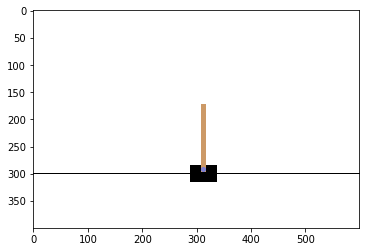

In [0]:
env = gym.make('CartPole-v0')

# 這裡我們不取得那些超參數，因為不需要更新 Q-Table
total_rewards = 0.0
observation = env.reset()
for t in range(250):
    state = get_state(observation, n_buckets, state_bounds) # 將觀察值轉為計算狀態組合
    action = choose_action(state, q_table, env.action_space, 0.0) # 根據 Q-Table 選擇行動
                                                                  # 這裡將 epsilon 機率設為 0 防止亂走
    observation, reward, done, info = env.step(action) # 執行行動
    total_rewards += reward

    print("第 {} 個時間點，已選擇行動 {}，目前累計獎勵：{}".format(t+1, action, total_rewards))
    env.render() # 顯示目前的環境狀態
    
    if done: # 若達終止條件，則結束執行
        break

env.close()

print("環境已達終止條件，總共獲得獎勵：", total_rewards)